In [12]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import os
import shutil
import subprocess
import gc
import xarray as xr
import numpy as np
import pymp

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import Bbox
from matplotlib.patches import FancyBboxPatch
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from functions.mandyocIO import read_mandyoc_output, read_datasets, read_particle_path, single_plot, change_dataset

# Initial setup

In [13]:
path = os.getcwd().split('/') # Get local file
machine_path = '/'+path[1]+'/'+path[2] # Select home according to OS.

# Path to the model directory

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc10_DT200_PT1292oC_lit80km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc1_DT290_PT1350oC_lit80km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc10_DT290_PT1350oC_lit80km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1397oC/1x1km2/NHK/RFT_Clc1_DT350_PT1397oC_lit80km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1397oC/1x1km2/NHK/RFT_Clc10_DT350_PT1397oC_lit80km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT400_PT1437oC/1x1km2/NHK/RFT_Clc1_DT400_PT1437oC_lit80km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT400_PT1437oC/1x1km2/NHK/RFT_Clc10_DT400_PT1437oC_lit80km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc1_DT200_PT1352oC_lit150km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc10_DT200_PT1352oC_lit150km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT290_PT1421oC/1x1km2/NHK/RFT_Clc1_DT290_PT1421oC_lit150km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT290_PT1421oC/1x1km2/NHK/RFT_Clc10_DT290_PT1421oC_lit150km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/1x1km2/NHK/RTF_Clc1_DT350_PT1460oC_lit150km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/1x1km2/NHK/RTF_Clc10_DT350_PT1460oC_lit150km_1x1km2_NHK' #ok

#Group 1 CLS - NoHprodAst
# scenario = '/Doutorado/cenarios/mandyoc/stable/NoHprodAst/stable_PT0_rheol19_1Gyr_400ppe_10x10_c_1250_C1' #ok
# scenario = '/Doutorado/cenarios/mandyoc/stable/NoHprodAst/stable_PT100_rheol19_c1250_C1' #ok
# scenario = '/Doutorado/cenarios/mandyoc/stable/NoHprodAst/stable_PT200_rheol19_c1250_C1' #ok

#Group 1 CLS - CRUST 40 km - NoHprodAst
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/crust40km/stable_DT200_lit80km_crust40km_HprodAst'
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/crust40km/stable_DT290_lit80km_crust40km_HprodAst'
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/crust40km/stable_DT350_lit80km_crust40km_HprodAst'

# scenario = '/Doutorado/cenarios/mandyoc/stable/lit150km/crust40km/stable_DT200_lit150km_crust40km_HprodAst' #failed
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit150km/crust40km/stable_DT290_lit150km_crust40km_HprodAst'
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit150km/crust40km/stable_DT350_lit150km_crust40km_HprodAst' #failed

#Group 2 CPE - HprodAst
#lit80km
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT200_rheol19_c1250_C1_HprodAst' #ok
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT280_rheol19_c1250_C1_HprodAst' #ok
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT290_rheol19_c1250_C1_HprodAst' #ok
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT350_rheol19_c1250_C1_HprodAst' #ok
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT400_rheol19_c1250_C1_HprodAst' #ok
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT500_rheol19_c1250_C1_HprodAst_Hlit80km'

#lit150km
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit150km/stable_DT200_rheol19_c1250_C1_HprodAst_Hlit150km/'#ok
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit150km/stable_DT290_rheol19_c1250_C1_HprodAst_Hlit150km/'#ok
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit150km/stable_DT350_rheol19_c1250_C1_HprodAst_Hlit150km/'#ok

# scenario = '/Doutorado/cenarios/mandyoc/stable/lit150km/stable_DT350_rheol19_c1250_C1_HprodAst_Hlit150km'

#ACCORDION
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/no_mean_temp_litho/lit80km/DT290_PT1349oC/ACC_Clc1_DT290_PT1349oC_lit80km_4x4km2'
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT200_PT1352oC/ACC_Clc1_DT200_PT1352oC_lit150km_4x4km2_mtl'

#mean all
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_all/lit80km/DT200_PT1291oC/ACC_Clc1_DT200_PT1291_lit80km_4x4km2_ma'
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_all/lit80km/DT200_PT1291oC/ACC_Clc10_DT200_PT1291_lit80km_4x4km2_ma'

# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_all/lit80km/DT290_PT1349oC/ACC_Clc10_DT290_PT1349_lit80km_4x4km2_ma'
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_all/lit80km/DT290_PT1349oC/ACC_Clc1_DT290_PT1349_lit80km_4x4km2_ma'

# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_all/lit80km/DT350_PT1397oC/ACC_Clc1_DT350_PT1397_lit80km_4x4km2_ma'
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_all/lit80km/DT350_PT1397oC/ACC_Clc10_DT350_PT1397_lit80km_4x4km2_ma'

# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_all/lit80km/DT400_PT1437oC/ACC_Clc1_DT400_PT1437_lit80km_4x4km2_ma'
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_all/lit80km/DT400_PT1437oC/ACC_Clc10_DT400_PT1437_lit80km_4x4km2_ma'

#Keel experiments

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/cold_keel/keel_stable_DT200_HprodAst_Lx3000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/cold_keel/keel_stable_DT290_HprodAst_Lx3000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/cold_keel/keel_stable_DT350_HprodAst_Lx3000km_ck'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/keel_stable_DT200_HprodAst_Lx4000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/keel_stable_DT290_HprodAst_Lx4000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/keel_stable_DT350_HprodAst_Lx4000km_ck'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/ast_wind/keel_stable_DT200_HprodAst_Lx4000km_ck_aw'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/ast_wind/keel_stable_DT290_HprodAst_Lx4000km_ck_aw'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/ast_wind/keel_stable_DT350_HprodAst_Lx4000km_ck_aw'


#Thermal boundary condition fixed
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/shift_craton/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf_sc'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/shift_craton/keel_stable_DT200_HprodAst_Lx4000km_ck_aw_tbcf_sc'

scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbwo'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/ast_wind/keel_stable_DT200_HprodAst_Lx4000km_ck_aw_tbcf'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/ast_wind/keel_stable_DT350_HprodAst_Lx4000km_ck_aw_tbcf'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/weak_keel/keel_stable_DT200_PT1292oC_HprodAst_Lx4000km_ck_tbcf_wk_Cmlit01'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/weak_keel/keel_stable_DT200_PT1292oC_HprodAst_Lx4000km_ck_tbcf_wk_Cmlit001'

#PARTIAL
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbwo/mbwo_partial'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo/mbdo_partial'

# local = True
local = False
if(local==True):
    model_path = machine_path + scenario
else:
    # scenario = '/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK'
    external_media = 'Joao_Macedo'
    model_path = f"/media/{machine_path.split('/')[-1]}/{external_media}{scenario}"

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True
plot_isotherms = True
# plot_melt = True
plot_melt = False
melt_method = 'dry'
# melt_method = 'wet'

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

model_name = scenario.split('/')[-1]

# Datasets handeling
## Model path

In [14]:
# Create the output directory to save the dataset
output_path = os.path.join(model_path, "_output")
print(output_path)

if not os.path.isdir(output_path):
    os.makedirs(output_path)

# model_name = os.path.split(model_path)[1]
# model_name = os.path.split(model_path)[0].split('/')[-1]
# model_name = scenario.split('/')[-1]

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select which ones you would like to plot
#              'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
#              'strain',
            #  'strain_rate',
            #  'temperature',
             'temperature_anomaly',
            #  'surface',
#              'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets

new_datasets = change_dataset(properties, datasets)

remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        new_datasets = change_dataset(properties, datasets)
        properties.remove('density')
        # remove_density=True

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in properties):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        properties.remove('temperature')
        
if (plot_melt): #add datasets needed to plot melt fraction
    if ('pressure' not in properties):
        properties.append('pressure')
    if ('temperature' not in properties):
        properties.append('temperature')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    properties.remove('pressure')
    properties.remove('temperature')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

# if(remove_density==True):
#     properties.remove('density')


for dataset in datasets:
    if not os.path.isfile(f"{model_path}/_output_{dataset}.nc"):
        print(f"Could not find dataset {dataset}. Creating missing dataset.")
        ds_data = read_mandyoc_output(
            model_path,
            datasets=dataset,
            parameters_file="param.txt"
        )     

if (save_big_dataset):
    dataset = read_datasets(model_path, new_datasets, save_big_dataset = True) 
else:
    dataset = read_datasets(model_path, new_datasets)
# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset.data_vars:
    v_max = np.max((dataset.velocity_x**2 + dataset.velocity_z**2)**(0.5))    
    dataset.velocity_x[:] = dataset.velocity_x[:] / v_max
    dataset.velocity_z[:] = dataset.velocity_z[:] / v_max
print(dataset.info)

/media/joaopedro/Joao_Macedo/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo/_output
<bound method Dataset.info of <xarray.Dataset>
Dimensions:      (time: 401, x: 401, z: 71)
Coordinates:
  * time         (time) float64 0.0 2.5 5.0 7.5 10.0 ... 992.5 995.0 997.5 1e+03
    step         (time) int32 0 500 1000 1500 ... 198500 199000 199500 200000
  * x            (x) float64 0.0 1e+04 2e+04 3e+04 ... 3.98e+06 3.99e+06 4e+06
  * z            (z) float64 -7e+05 -6.9e+05 -6.8e+05 ... -2e+04 -1e+04 0.0
Data variables:
    strain       (time, x, z) float64 ...
    density      (time, x, z) float64 ...
    temperature  (time, x, z) float64 ...
Attributes: (12/94)
    nx:                                401
    nz:                                71
    lx:                                4000000.0
    lz:                                700000.0
    multigrid:                         1
    solver:                

In [15]:
model_path, output_path, model_name

('/media/joaopedro/Joao_Macedo/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo',
 '/media/joaopedro/Joao_Macedo/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo/_output',
 'keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo')

In [16]:
unzip_steps = True

if(unzip_steps):
    !unzip {model_path}/{model_name}.zip step*.txt -d {model_path}

Archive:  /media/joaopedro/Joao_Macedo/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo.zip
  inflating: /media/joaopedro/Joao_Macedo/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo/step_0_0.txt  
  inflating: /media/joaopedro/Joao_Macedo/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo/step_0_10.txt  
  inflating: /media/joaopedro/Joao_Macedo/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo/step_0_11.txt  
  inflating: /media/joaopedro/Joao_Macedo/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo/step_0_12.txt  
  inflating: /med

# Plot using pymp

27681
26383
24385
17932
1069510224
22393

9797
14740
20723
19239
11219
15718
11776
13893
12421
1308216796

9423
28000
27681
1022410695

11219
147409797

1389324385

9423
17932
11776
2638328000

1242119239
22393

20723
15718
16796
13082
27602
10657
10207
14698
11194
9399
2426211752
9782

12390
20638
13852
26305
13047
17873
1672219168

15671
22303
28000
10207
10657
27602
11194
1469811752

12390
939913852
9782

24262
13047
17873
2630520638

2230328000

15671
16722
19168
10636
10186
27528
975511173

12341
11731
13798
9380
14662
24141
22199
13014
17828
1063616663

20565
28000
26224
19093
10186
15624
111739755

27528
13798
12341
11731
9380
14662
17828
13014

2219920565
16663
24141
26224
28000
10610
19093
15624
101629731

11139
11710
9360
27463
14622
12305
17774
1375720489

2404010610
22099

16612
12994
10162
26144
9731
28000
11139
11710
9360
19030
12305
27463
14622
20489
17774
15569
2404022099
13757

16612
26144
12994
10149
28000
10579
19030
11681
9713
11123
15569
9338
12273
14580
10149
1057

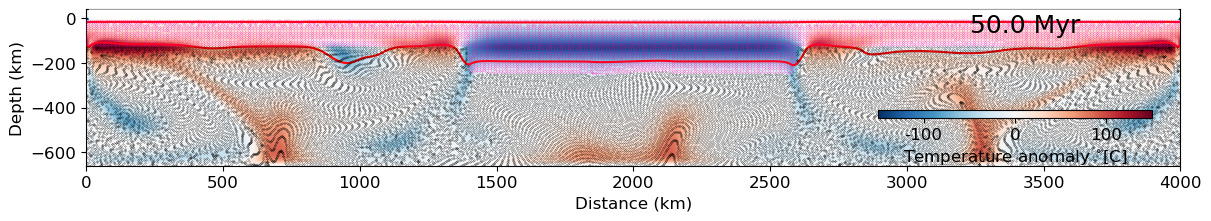

In [17]:
t0 = dataset.time[0]
t1 = dataset.time[1]
dt = int(t1 - t0)

start = int(t0)
end = int(dataset.time.size - 1)
step = 1#5

# start = 1
# end = 20
# step = 1

# step_initial = dataset.step[0]
# step_1 = dataset.step[1]
# step_final = dataset.step[-1]
# dstep = int(step_1 - step_initial)

plot_particles = True 
with pymp.Parallel() as p:
    for i in p.range(start, end+step, step):
        # data = dataset.isel(time=i)
        per = np.round(100*(i+1-start)/(end-start), 2)
        text = f"Time: {np.round(float(dataset.isel(time=i).time), 2)} Myr; Step: {int(dataset.isel(time=i).step)}/{int(dataset.step.max())}, ({per:.2f}%)."
        
        # print(text, end='\r')
        
        for prop in properties:
    #         print(f"Handeling {prop}.", end='\n')
            if(prop != 'surface'): # you can customize
                xlims = [0, float(dataset.isel(time=i).lx) / 1.0e3]
                ylims = [-float(dataset.isel(time=i).lz) / 1.0e3 + 40, 40]
            else:
                xmin = 0 #+ 200
                xmax = float(dataset.isel(time=i).lx) / 1.0E3 #- 200
                xlims = [xmin, xmax]
                ylims = [-7, 7]
               
            single_plot(dataset.isel(time=i), prop, xlims, ylims, model_path, output_path,
                        plot_isotherms = plot_isotherms,
                        plot_particles = plot_particles,
                        isotherms = [500, 1300],
                        plot_melt = plot_melt,
                        melt_method = melt_method)
            
            # single_plot(dataset.isel(time=i), prop, xlims, ylims, model_path, output_path, plot_isotherms=False, isotherms = [500, 1300])
    #     print((n+1)*'\033[F', end='')

In [18]:
# model_name
# dataset.time

# Making videos

In [19]:
fps = 30
    
for prop in properties:
    videoname = f'{model_path}/_output/{model_name}_{prop}'

    if(plot_melt):
        videoname = f'{videoname}_MeltFrac_{melt_method}'

    if(plot_particles):
        videoname = f'{videoname}_particles'
        
    !rm {videoname}.mp4
    # !ffmpeg -r {fps} -f image2 -s 1920x1080 -pattern_type glob -i '{model_path}/_output/{model_name}_{prop}_*.png' -vcodec libx264 -crf 25 -pix_fmt yuv420p {model_path}/_output/{model_name}_{prop}.mp4
    !ffmpeg -r {fps} -f image2 -s 1920x1080 -pattern_type glob -i '{videoname}_*.png' -vcodec libx264 -vf 'pad=ceil(iw/2)*2:ceil(ih/2)*2' -r 24 -y -an -crf 25 -pix_fmt yuv420p {videoname}.mp4


ffmpeg version 6.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-3)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699837816504/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699837816504/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699837816504/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699837816504/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699837816504/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-libdav

# Converting videos to gifs

ss: skip seconds

t: duration time of the output

i: inputs format

vf: filtergraph (video filters)

    - fps: frames per second

    - scale: resize accordint to given pixels (e.g. 1080 = 1080p wide)
    
    - lanczos: scaling algorithm
    
    - palettegen and palette use: filters that generate a custom palette
    
    - split: filter that allows everything to be done in one command

loop: number of loops

    - 0: infinite

    - -1: no looping

    - for numbers n >= 0, create n+1 loops

In [20]:
# converting mp4 to gif
for prop in properties:
    gifname = f'{model_path}/_output/{model_name}_{prop}'

    if(plot_melt):
        gifname = f'{gifname}_MeltFrac_{melt_method}'

    if(plot_particles):
        gifname = f'{gifname}_particles'
        
    !rm {gifname}.gif
    !ffmpeg -ss 0 -t 20 -i '{gifname}.mp4' -vf "fps=120,scale=1080:-1:flags=lanczos,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse" -loop 0 {gifname}.gif

ffmpeg version 6.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-3)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699837816504/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699837816504/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699837816504/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699837816504/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699837816504/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-libdav

# Zipping files

In [21]:
#zip plots, videos and gifs using external script zip_plots

script_path = f"/home/{machine_path.split('/')[-1]}/opt/mandyoc-scripts/"
outputs_path = f'{model_path}/_output/'

script_name = 'zip_plots.sh'
script_path = os.path.join(script_path, script_name)

os.chdir(outputs_path)
last_folder = os.path.basename(os.path.normpath(outputs_path)) 
subprocess.run(["bash", script_path])

Zipping keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo directory...
updating: keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo_lithology_particles_000000.png (deflated 15%)
updating: keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo_lithology_particles_000500.png (deflated 13%)
updating: keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo_lithology_particles_001000.png (deflated 12%)
updating: keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo_lithology_particles_001500.png (deflated 11%)
updating: keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo_lithology_particles_002000.png (deflated 9%)
updating: keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo_lithology_particles_002500.png (deflated 8%)
updating: keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo_lithology_particles_003000.png (deflated 7%)
updating: keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo_lithology_particles_003500.png (deflated 6%)
updating: keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo_lithology_particles_004000.png (deflated 5%)
updating: keel_stable_DT200_HprodAst_Lx4

CompletedProcess(args=['bash', '/home/joaopedro/opt/mandyoc-scripts/zip_plots.sh'], returncode=0)

In [22]:
!rm {model_path}/step*.txt

# Plot data - single core

In [ ]:
t0 = dataset.time[0]
t1 = dataset.time[1]
dt = int(t1 - t0)

start = int(t0)
end = int(dataset.time.size - 1)
step = 1#5

# start = 0
# end = 1
# step = 1

# step_initial = dataset.step[0]
# step_1 = dataset.step[1]
# step_final = dataset.step[-1]
# dstep = int(step_1 - step_initial)

for i in range(start, end+step, step):
    data = dataset.isel(time=i)
    per = np.round(100*(i+1-start)/(end-start), 2)
    text = f"Time: {np.round(float(data.time), 2)} Myr; Step: {int(data.step)}/{int(dataset.step.max())}, ({per:.2f}%)."
    
    print(text, end='\r')
    
    for prop in properties:
#         print(f"Handeling {prop}.", end='\n')
        if(prop != 'surface'): # you can customize
            xlims = [0, float(data.lx) / 1.0e3]
            ylims = [-float(data.lz) / 1.0e3 + 40, 40]
        else:
            xmin = 0 #+ 200
            xmax = float(data.lx) / 1.0E3 #- 200
            xlims = [xmin, xmax]
            ylims = [-7, 7]
            
        single_plot(data, prop, xlims, ylims, model_path, output_path, plot_isotherms=True, isotherms = [500, 1300])
        # single_plot(data, prop, xlims, ylims, model_path, output_path, plot_isotherms=False, isotherms = [500, 1300])
#     print((n+1)*'\033[F', end='')